### Analysis software development 

Goal: establish smooth reading of the binary DAQ datafiles

In [1]:
import sys
sys.path.insert(0,'python/')
import struct
import matplotlib.pyplot as plt
import numpy as np
# import data handling class
from DT5550 import *

Filename to process

In [2]:
filename = '../daq/ReadoutClient/test.raw'
#filename = '../daq/ReadoutClient/na22_tmode0_1M.raw'
#filename = '../daq/ReadoutClient/na22_tmode1_670k.raw'

Open a datafile and read the data

In [3]:
#
# open the datfile
#
print('Open datafile:',filename)
io = DT5550(file=filename)
#
# loop over the data
#
Q0 = []
Q1 = []
t0 = []
t1 = []
nvalid = []

nhit = np.zeros(8)
while(io.read_event() == 0):
    if io.n_event%10000 == 0:
        print('Processed ',io.n_event,' events')
    # here you can decide what to do with the event information
    # ......
    #for id in range(8):
    n=0
    for i in range(8):
#        print(i,io.Q[i],io.t[i],io.valid[i])

        if io.valid[i]:
            n = n+1
            nhit[i] = nhit[i]+1
    nvalid.append(n)
    
    if n == 2:
        t0.append(io.t[0])
        t1.append(io.t[1])

t0 = np.array(t0)
t1 = np.array(t1) 
print('Processing done')

Open datafile: ../daq/ReadoutClient/test.raw


FileNotFoundError: [Errno 2] No such file or directory: '../daq/ReadoutClient/test.raw'

Text(0, 0.5, '$Q_1$')

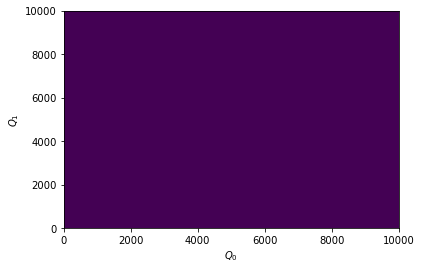

In [4]:
import matplotlib as mpl

h = plt.hist2d(Q0,Q1,bins=(100,100),range=((0,10000),(0,10000)),norm=mpl.colors.LogNorm())
plt.xlabel('$Q_0$')
plt.ylabel('$Q_1$')

(0.1, 2000000.0)

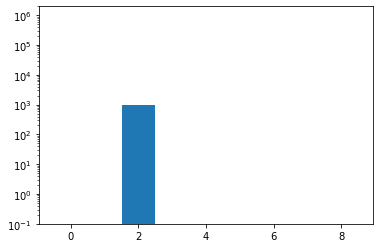

In [5]:
h = plt.hist(nvalid, bins=9, range=(-0.5,8.5))
plt.yscale('log')
plt.ylim((0.1,2e6))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  This is separate from the ipykernel package so we can avoid doing imports until


(0.1, 10000.0)

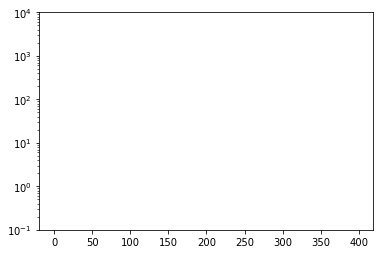

In [6]:
h = plt.hist(t0,bins=200,range=(-0.5,399.5),histtype='bar')
h = plt.hist(t1,bins=200,range=(-0.5,399.5),histtype='step')
plt.yscale('log')
plt.ylim([0.1,1e4])

A few basic plots: integrated charge and time

python\DT5550.py:138: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


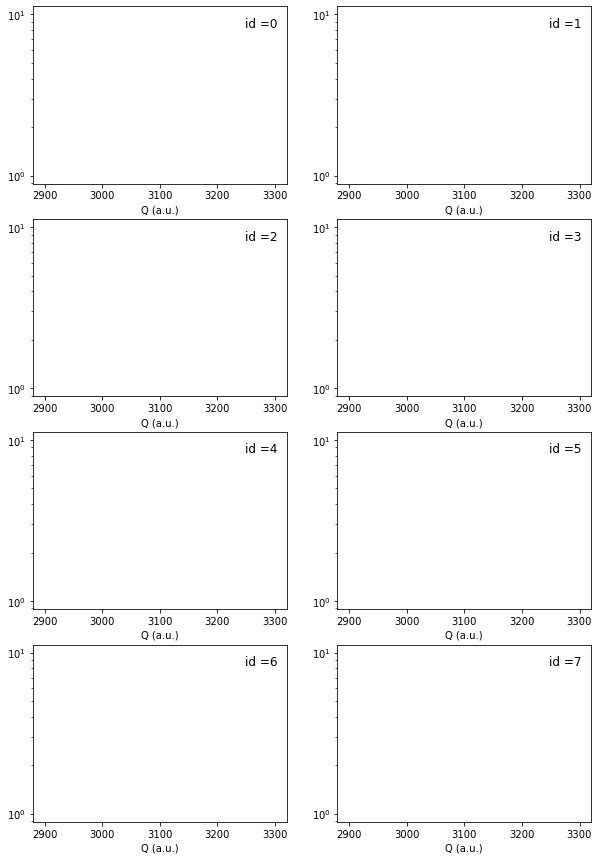

In [7]:
io.plot_all(type="charge",bins=100,logy=True, range=(2900,3300))

python\DT5550.py:113: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


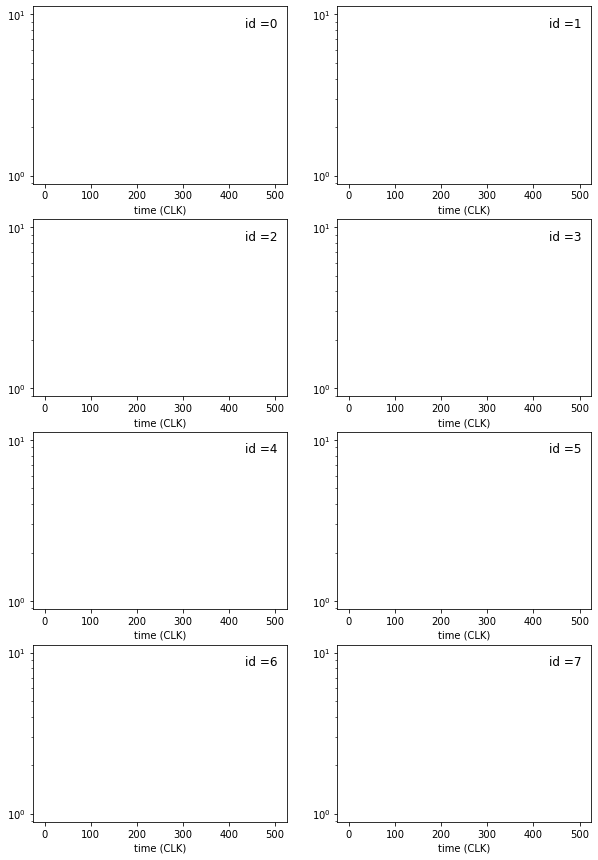

In [8]:
io.plot_all(type="time",range=(0,500),bins=100,logy=True)

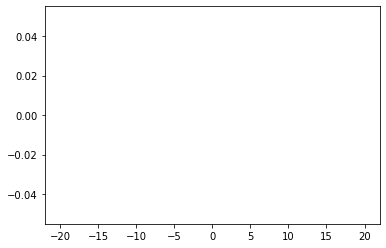

In [9]:
h=plt.hist((np.array(t0)-np.array(t1)),bins=100,range=(-20,20))


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  


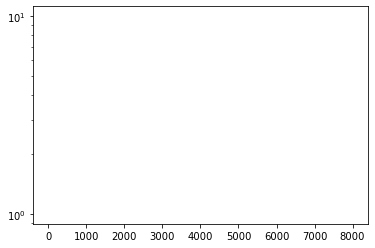

In [10]:
h=plt.hist(Q0,bins=100,range=(0,8000))
plt.yscale('log')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  


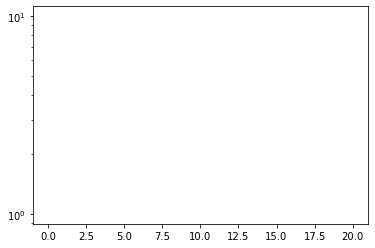

In [11]:
h=plt.hist(t0,bins=100,range=(0,20))
plt.yscale('log')

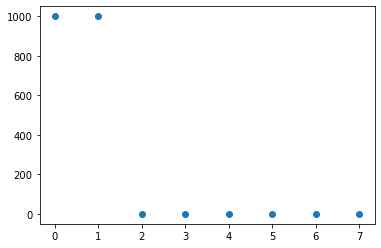

In [12]:
h = plt.plot(nhit,'o')

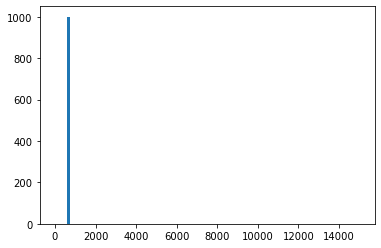

In [13]:
h = plt.hist(t0,bins=100,range=(0,15000))

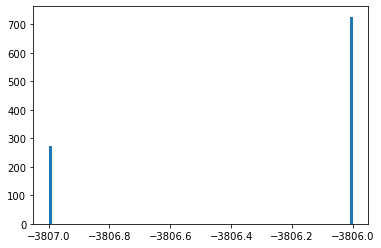

In [14]:
h= plt.hist(t0-t1,bins=100)

In [15]:
(t0-t1)[0]

-3806.0

In [16]:
0ns: (t0-t1).mean()*12.5/16

SyntaxError: invalid syntax (Temp/ipykernel_18144/3764098699.py, line 1)

In [17]:
(t0-t1).mean()*12.5/16

-2973.65078125

In [19]:
(t0-t1).mean()*12.5/16

24.93125